In [204]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [205]:
import numpy as np
from collections import defaultdict
import copy
import random
import datetime
import os
import sys
import shutil
from urllib.request import urlretrieve
import collections
import math
import time
import logging
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

cudnn.benchmark = True
model_save_name ='exp8'

In [206]:
root_directory = "/content/drive/MyDrive/dataset"

fields_directory = os.path.join(root_directory, "fields")
roads_directory = os.path.join(root_directory, "roads")

fields_images_filepaths = sorted([os.path.join(fields_directory, f) for f in os.listdir(fields_directory)])
roads_images_filepaths = sorted([os.path.join(roads_directory, f) for f in os.listdir(roads_directory)])
images_filepaths = [*fields_images_filepaths, *roads_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:137]
val_images_filepaths = correct_images_filepaths[137:153]

print(len(train_images_filepaths), len(val_images_filepaths))

137 16


In [207]:
class FieldsVsRoadsDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "fields":
            label = torch.tensor([1.0, 0.0])
        else:
            label = torch.tensor([0.0, 1.0])
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [208]:
train_transform = A.Compose(
    [
        A.Resize(250,300),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=250, width=250),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = FieldsVsRoadsDataset(images_filepaths=train_images_filepaths, transform=train_transform)

In [209]:
val_transform = A.Compose(
    [
        A.Resize(250,300),
        A.CenterCrop(height=250, width=250),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = FieldsVsRoadsDataset(images_filepaths=val_images_filepaths, transform=val_transform)

In [210]:
def visualize_augmentations(dataset, idx=15, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

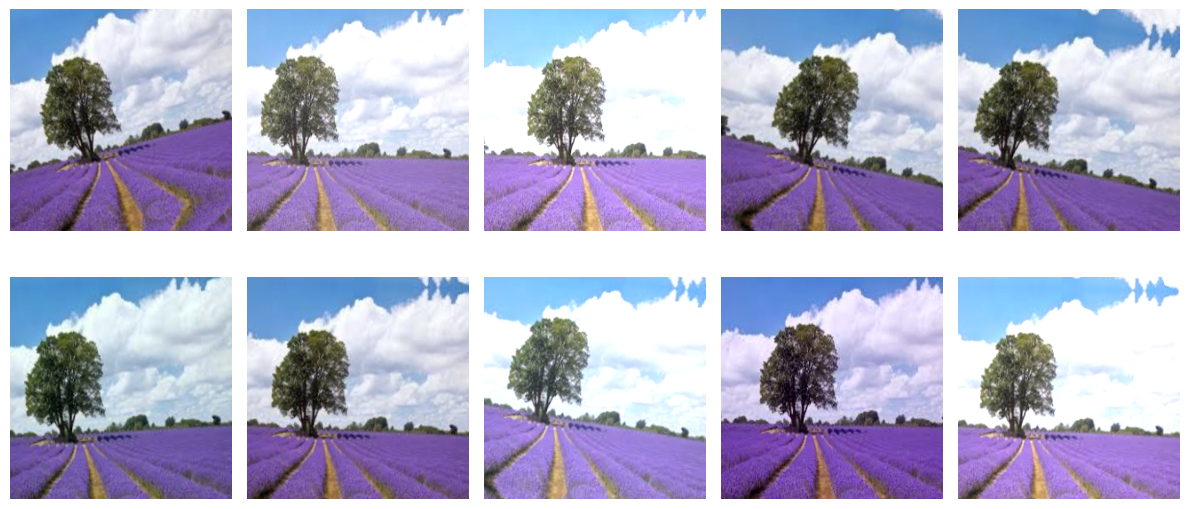

In [211]:
random.seed(24)
visualize_augmentations(train_dataset)

In [212]:
def calculate_accuracy(output, target):
    """output = torch.sigmoid(output) >= 0.5
    target = target == 1.0"""
    #print("target.shape", target)
    _, target = torch.max(target, 1)
    #print("target.shape", target)
    #print("output.shape", output)
    _, output = torch.max(output, 1)
    #print("output.shape", output)
    return torch.true_divide((target == output).sum(), output.size(0)).item()

In [213]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [214]:
params = {
    "model": "resnet18",
    "device": torch.device("cuda" if (torch.cuda.is_available()) else "cpu"),
    "lr": 0.00001,
    "batch_size": 10,
    "epochs": 50,
}

In [215]:
"""model = getattr(models, params["model"])(pretrained=False, num_classes=1,)
model = model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])"""

'model = getattr(models, params["model"])(pretrained=False, num_classes=1,)\nmodel = model.to(params["device"])\ncriterion = nn.BCEWithLogitsLoss().to(params["device"])\noptimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])'

In [216]:
model = getattr(models, params["model"])(pretrained=True)
model = model.to(params["device"])
num_classes=2
fc_out_features = model.fc.out_features
print(fc_out_features)
classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(fc_out_features, num_classes)
        ).to(params["device"])

criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]

1000


In [217]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False)

In [218]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images)
        outputs = classifier(output)
        output = nn.functional.softmax(outputs, dim=1).to(params["device"])
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    return loss, accuracy

In [219]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images)
            outputs = classifier(output)
            output = nn.functional.softmax(outputs, dim=1)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
        return loss,accuracy

In [220]:
def create_logfile(model_save_name):
    # logging
    os.makedirs("/content/drive/MyDrive/logs", exist_ok=True)
    log_path = os.path.join("logs", model_save_name) + ".txt"
    if os.path.exists(log_path):
        os.remove(log_path)
    logging.basicConfig(
        level=logging.INFO,
        format="%(message)s",
        handlers=[
            logging.FileHandler(log_path),
            logging.StreamHandler(sys.stdout)
        ]
    )
    logger = logging.getLogger()
    
    return logger

In [221]:
# model saving
best_val_loss = math.inf
early_stopping = collections.deque(maxlen=int(3))
model_save_dir='/content/drive/MyDrive/saved_weights'
os.makedirs('/content/drive/MyDrive/saved_weights', exist_ok=True)
#start the timer to compute training time
start = time.time()
for epoch in range(1, params["epochs"] + 1):
    logger = create_logfile(model_save_dir+model_save_name)    
    logger.info("Script starting {}\n".format(time.strftime("%Y-%m-%d %H:%M")))
    
    train_loss, train_accuracy = train(train_loader, model, criterion, optimizer, epoch, params)
    val_loss, val_accuracy = validate(val_loader, model, criterion, epoch, params)
    # save if better on val_loss
    if val_loss < best_val_loss:
        model_save_path = os.path.join(model_save_dir, model_save_name + "_best.pt")
        best_val_loss = val_loss
        logger.info("\tSaving model to {}".format(model_save_path))
        save_dict = {
            "state_dict": model.state_dict(),
            "epoch": epoch,
            "optimizer_state_dict": optimizer.state_dict()
            }
        torch.save(save_dict, model_save_path)
        
    early_stopping.append(val_loss.cpu().numpy())
    if len(early_stopping) >= early_stopping.maxlen:
        # if all elements in list are higher than best_val_loss
        if all(np.array(early_stopping)> best_val_loss.cpu().numpy()):
            model_save_path = os.path.join(model_save_dir, model_save_name + "_e{}".format(epoch) + ".pt")
            logger.info("\tSaving model to {} for early stopping".format(model_save_path))
            save_dict = {
                "state_dict": model.state_dict(),
                "epoch": epoch,
                "optimizer_state_dict": optimizer.state_dict()
                }
            torch.save(save_dict, model_save_path)
            end = time.time()
            exec_time = datetime.timedelta(seconds=end - start)
            logger.info("Running time {}".format(str(exec_time)))

            break
        else:
            index_max = np.argmin(np.array(early_stopping))
            logger.info("\tBest val loss was reached {} epochs ago".format(len(early_stopping) - index_max))


Epoch: 1. Train.      Loss: 0.659 | Accuracy: 0.618: 100%|██████████| 14/14 [00:02<00:00,  5.09it/s]
Epoch: 1. Validation. Loss: 0.569 | Accuracy: 0.767: 100%|██████████| 2/2 [00:00<00:00,  8.16it/s]
Epoch: 2. Train.      Loss: 0.543 | Accuracy: 0.765: 100%|██████████| 14/14 [00:03<00:00,  3.80it/s]
Epoch: 2. Validation. Loss: 0.499 | Accuracy: 0.800: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]
Epoch: 3. Train.      Loss: 0.490 | Accuracy: 0.847: 100%|██████████| 14/14 [00:02<00:00,  5.15it/s]
Epoch: 3. Validation. Loss: 0.448 | Accuracy: 0.817: 100%|██████████| 2/2 [00:00<00:00,  8.32it/s]
Epoch: 4. Train.      Loss: 0.423 | Accuracy: 0.926: 100%|██████████| 14/14 [00:02<00:00,  5.14it/s]
Epoch: 4. Validation. Loss: 0.453 | Accuracy: 0.850: 100%|██████████| 2/2 [00:00<00:00,  8.48it/s]
Epoch: 5. Train.      Loss: 0.401 | Accuracy: 0.926: 100%|██████████| 14/14 [00:02<00:00,  5.14it/s]
Epoch: 5. Validation. Loss: 0.505 | Accuracy: 0.767: 100%|██████████| 2/2 [00:00<00:00,  7.90it/s]


In [222]:
class FieldsVsRoadsInferenceDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image

test_transform = A.Compose(
    [
        A.Resize(250,300),
        A.CenterCrop(height=250, width=250),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_images_filepaths = sorted([os.path.join('/content/drive/MyDrive/dataset/test_images', f) for f in os.listdir('/content/drive/MyDrive/dataset/test_images')])
test_dataset = FieldsVsRoadsInferenceDataset(images_filepaths=test_images_filepaths, transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False)

In [223]:
checkpoint = torch.load(model_save_dir+'/'+model_save_name+'_best.pt', map_location=params["device"])
model.load_state_dict(checkpoint["state_dict"])
model = model.eval()
predicted_labels = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(params["device"], non_blocking=True)
        output = model(images)
        outputs = classifier(output)
        output = nn.functional.softmax(outputs, dim=1)
        #predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
        _, predictions = torch.max(output, 1)
        predicted_labels += ["Field" if is_field else "Road" for is_field in predictions]

In [224]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=4):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        predicted_label = predicted_labels[i] 
        color = "green" 
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

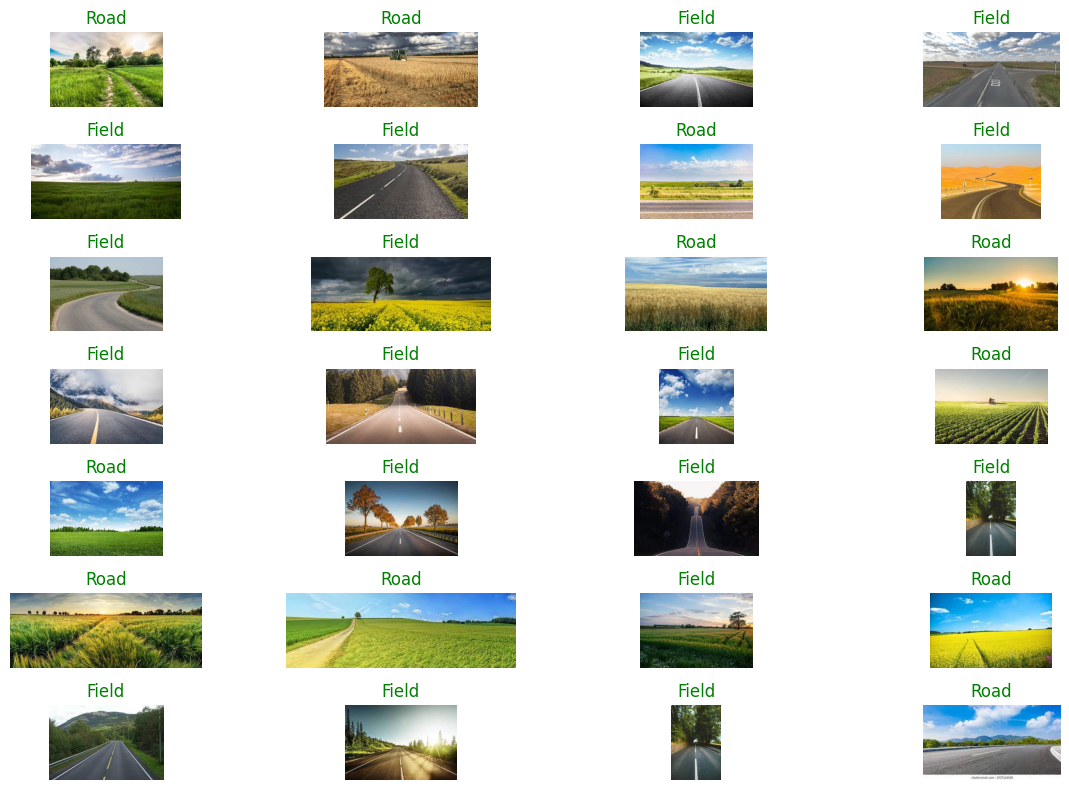

In [225]:
display_image_grid(test_images_filepaths, predicted_labels)